In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/awohns/Documents/tspyro/")

import tspyro
import tskit
import tsdate

import numpy as np
import msprime
import torch
from pyro import poutine

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

from sklearn.metrics import mean_squared_error, mean_squared_log_error

from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

import pyslim

# Example 1: A tree sequence produced by msprime (no locations)

In [2]:
msprime_ts = tskit.load("coalescent_sim.trees")
# This tree sequence can be reproduced with the following code:
# ts = msprime.simulate(500, Ne=2000, mutation_rate=1e-8, recombination_rate=1e-8, random_seed=1)

In [3]:
msprime_ts

In [4]:
# We can estimate the times of the tree sequence (without location)
# Specify the correct Ne and mutation rate
priors = tsdate.build_prior_grid(msprime_ts, Ne=2000)
inferred_times_marginal, _, _, guide_marginal, losses_marginal = tspyro.models.fit_guide(
    msprime_ts, leaf_location=None, priors=priors, mutation_rate=1e-8, steps=10000, log_every=1000)

step 0 loss = 17.686, Migration scale= 0.9950327277183533
step 1000 loss = 1.9799, Migration scale= 1.0220550298690796
step 2000 loss = 2.1186, Migration scale= 1.013162612915039
step 3000 loss = 2.7436, Migration scale= 0.9747270941734314
step 4000 loss = 2.2124, Migration scale= 0.9452072978019714
step 5000 loss = 2.0752, Migration scale= 1.0712567567825317
step 6000 loss = 2.7762, Migration scale= 1.1278220415115356
step 7000 loss = 2.2667, Migration scale= 1.071947693824768
step 8000 loss = 2.3811, Migration scale= 1.0437334775924683
step 9000 loss = 2.3481, Migration scale= 1.0606372356414795


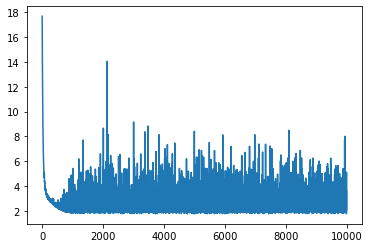

In [5]:
plt.plot(losses_marginal)

In [6]:
# We can estimate the times of the tree sequence (without location)
# Specify the correct Ne and mutation rate
priors = tsdate.build_prior_grid(msprime_ts, Ne=2000)
inferred_times_marginal_init_true, _, _, guide_marginal_init_true, losses_marginal_init_true = tspyro.models.fit_guide(
    msprime_ts, leaf_location=None, priors=priors, mutation_rate=1e-8, steps=10000, log_every=1000,
    init_times=torch.tensor(msprime_ts.tables.nodes.time[msprime_ts.num_samples:], dtype=torch.float))

step 0 loss = 3.8524, Migration scale= 0.9950327277183533
step 1000 loss = 1.9038, Migration scale= 1.0220550298690796
step 2000 loss = 2.0946, Migration scale= 1.013162612915039
step 3000 loss = 2.8328, Migration scale= 0.9747270941734314
step 4000 loss = 2.2714, Migration scale= 0.9452072978019714
step 5000 loss = 2.064, Migration scale= 1.0712567567825317
step 6000 loss = 2.7577, Migration scale= 1.1278220415115356
step 7000 loss = 2.2513, Migration scale= 1.071947693824768
step 8000 loss = 2.3906, Migration scale= 1.0437334775924683
step 9000 loss = 2.3841, Migration scale= 1.0606372356414795


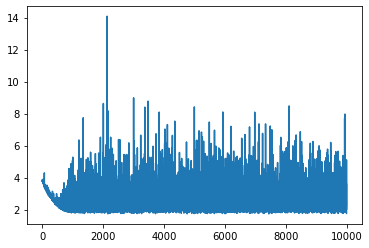

In [7]:
plt.plot(losses_marginal_init_true)

In [8]:
dated = tsdate.date(msprime_ts, mutation_rate=1e-8, Ne=2000)

MSLE of tspyro is 0.29936782865158373
MSLE of tspyro_init_true is 0.2990658016284634
MSLE of tsdate is 0.2582001571511334


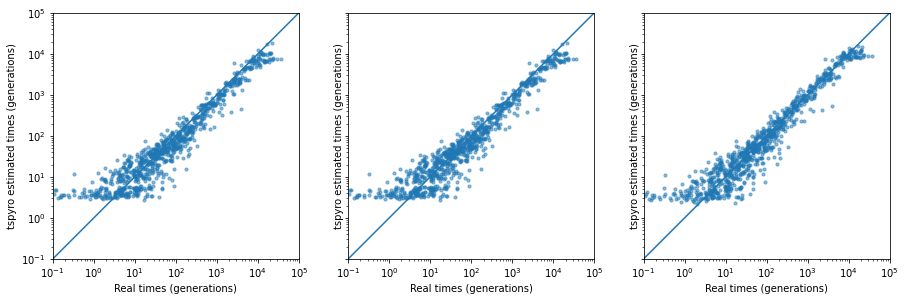

In [9]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,10))

estimated_times = [inferred_times_marginal, inferred_times_marginal_init_true, dated.tables.nodes.time]
estimation_names = ["tspyro", "tspyro_init_true", "tsdate"]
for ax, name, times in zip(axes, estimation_names, estimated_times):
    ax.set_aspect('equal')
    ax.scatter(msprime_ts.tables.nodes.time, times, s=10, alpha=0.5)
    ax.set_xlim(0.1, 100000)
    ax.set_ylim(0.1, 100000)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(ax.get_xlim(), ax.get_ylim())
    ax.set_xlabel("Real times (generations)")
    ax.set_ylabel("tspyro estimated times (generations)")
    print("MSLE of {} is {}".format(name, mean_squared_log_error(msprime_ts.tables.nodes.time, times)))

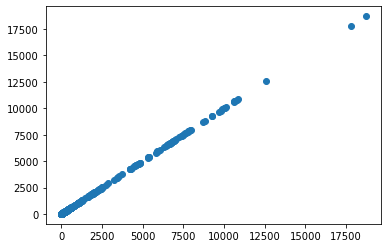

In [10]:
plt.scatter(inferred_times_marginal, inferred_times_marginal_init_true)

# Example 2: SLiM tree sequence

In [27]:
ts = tskit.load("slim_2d_continuous_recapitated_mutated.trees")


In [28]:
# Now let's randomly sample 200 leaf nodes
rng = np.random.default_rng(20)
random_sample = np.random.choice(np.arange(0, ts.num_samples), 200, replace=False)
sampled_ts = ts.simplify(samples=random_sample)

In [13]:
sampled_ts

In [14]:
# Next, we need to get the locations of the nodes
node_locations = np.full((sampled_ts.num_nodes, 2), -1, dtype=float)
no_location_nodes = []
for node in sampled_ts.nodes():
    if node.individual != -1:
        node_locations[node.id, :] = sampled_ts.individual(node.individual).location[:2]
    else:
        no_location_nodes.append(node.id)
# We want a tensor with only the leaf nodes for inference
leaf_locations = torch.tensor(node_locations[sampled_ts.samples()])



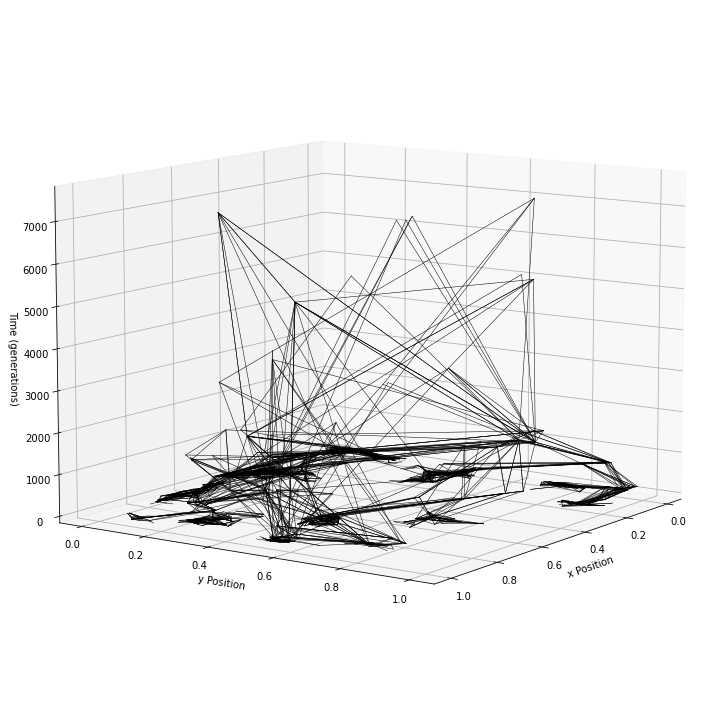

In [15]:
# Let's visualize the tree sequence in three dimensions
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
times = sampled_ts.tables.nodes.time
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = node_locations[edge.child]
        parent_loc = node_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="black", linewidth=0.5)

ax.set_xlabel("x Position")
ax.set_ylabel("y Position")
ax.set_zlabel("Time (generations)")
ax.view_init(10, 35)
plt.tight_layout()

In [16]:
# Marginal inference of time

priors = tsdate.build_prior_grid(sampled_ts, Ne=1000)
slim_inferred_times_marginal, _, _, slim_guide_marginal, slim_losses_marginal = tspyro.models.fit_guide(
    sampled_ts, leaf_location=None,
    migration_likelihood=None,
    priors=priors, mutation_rate=1e-8, steps=10000, log_every=1000)



step 0 loss = 11.384, Migration scale= 1.0050076246261597
step 1000 loss = 3.7662, Migration scale= 0.9858092069625854
step 2000 loss = 4.6242, Migration scale= 0.8508595824241638
step 3000 loss = 5.2099, Migration scale= 0.9566498398780823
step 4000 loss = 4.6891, Migration scale= 0.9623016119003296
step 5000 loss = 3.9132, Migration scale= 0.8759832978248596
step 6000 loss = 4.6926, Migration scale= 0.9657100439071655
step 7000 loss = 4.3005, Migration scale= 0.9409698247909546
step 8000 loss = 3.795, Migration scale= 0.9520137310028076
step 9000 loss = 3.6568, Migration scale= 0.9771431684494019


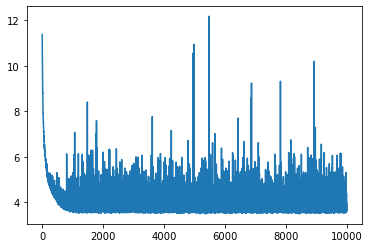

In [17]:
plt.plot(slim_losses_marginal)

In [18]:
# Let's perform joint inference of time and location

# We restrict inference of locations to nodes within 100 generations of the samples (which are all at time zero)
masked = sampled_ts.tables.nodes.time >= 100
mask = torch.ones(sampled_ts.num_edges, dtype=torch.bool)
for e, edge in enumerate(sampled_ts.edges()):
    if masked[edge.child]:
        mask[e] = False
migration_likelihood = tspyro.models.euclidean_migration
migration_likelihood = poutine.mask(
    migration_likelihood, mask=mask)

priors = tsdate.build_prior_grid(sampled_ts, Ne=1000)
slim_inferred_times_joint, slim_inferred_locations, slim_migration_scale_joint, slim_guide_joint, slim_losses_joint = tspyro.models.fit_guide(
    sampled_ts, leaf_location=leaf_locations,
    migration_likelihood=migration_likelihood,
    priors=priors, mutation_rate=1e-8, steps=10000, log_every=1000)



step 0 loss = 27.539, Migration scale= 0.9950136542320251
step 1000 loss = 0.96615, Migration scale= 0.014347758144140244
step 2000 loss = -0.66234, Migration scale= 0.008206965401768684
step 3000 loss = -1.2864, Migration scale= 0.007244548760354519
step 4000 loss = -0.68478, Migration scale= 0.00687428517267108
step 5000 loss = -1.3971, Migration scale= 0.006628580391407013
step 6000 loss = -1.2143, Migration scale= 0.006501711439341307
step 7000 loss = -0.99228, Migration scale= 0.006397421006113291
step 8000 loss = -1.2793, Migration scale= 0.006371322087943554
step 9000 loss = -1.37, Migration scale= 0.006281685084104538


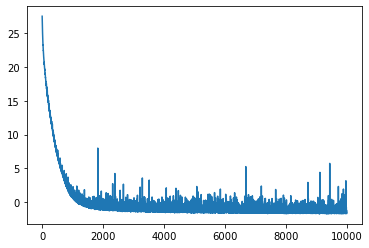

In [19]:
plt.plot(slim_losses_joint)

In [20]:
# Let's perform joint inference of time and location: initalize to true locations

# We restrict inference of locations to nodes within 100 generations of the samples (which are all at time zero)
masked = sampled_ts.tables.nodes.time >= 100
mask = torch.ones(sampled_ts.num_edges, dtype=torch.bool)
for e, edge in enumerate(sampled_ts.edges()):
    if masked[edge.child]:
        mask[e] = False
migration_likelihood = tspyro.models.euclidean_migration
migration_likelihood = poutine.mask(
    migration_likelihood, mask=mask)

priors = tsdate.build_prior_grid(sampled_ts, Ne=1000)
slim_inferred_times_joint, slim_inferred_locations, slim_migration_scale_joint, slim_guide_joint, slim_losses_joint = tspyro.models.fit_guide(
    sampled_ts, leaf_location=leaf_locations,
    migration_likelihood=migration_likelihood,
    init_loc=node_locations,
    priors=priors, mutation_rate=1e-8, steps=10000, log_every=1000)




TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray

In [63]:
dated_slim = tsdate.date(sampled_ts, mutation_rate=1e-8, Ne=1000)


MSLE of tspyro_marginal is 0.21817737774536194
MSLE of tspyro_joint is 0.38151360064164214
MSLE of tsdate is 0.20083636602613436


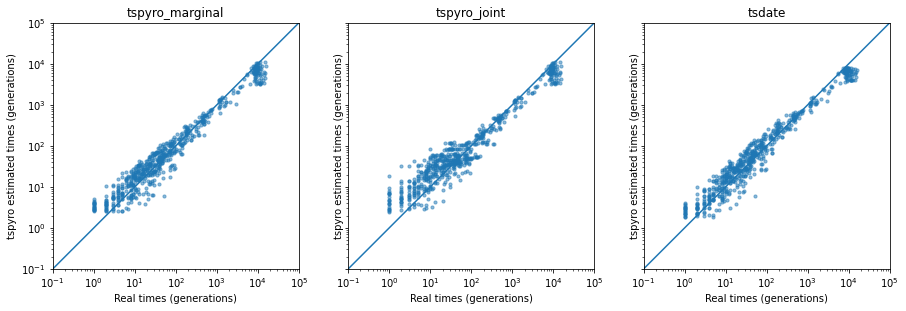

In [64]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,10))

estimated_times = [slim_inferred_times_marginal, slim_inferred_times_joint, dated_slim.tables.nodes.time]
estimation_names = ["tspyro_marginal", "tspyro_joint", "tsdate"]
for ax, name, times in zip(axes, estimation_names, estimated_times):
    ax.set_aspect('equal')
    ax.scatter(sampled_ts.tables.nodes.time, times, s=10, alpha=0.5)
    ax.set_xlim(0.1, 100000)
    ax.set_ylim(0.1, 100000)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(ax.get_xlim(), ax.get_ylim())
    ax.set_xlabel("Real times (generations)")
    ax.set_ylabel("tspyro estimated times (generations)")
    ax.set_title(name)
    print("MSLE of {} is {}".format(name, mean_squared_log_error(sampled_ts.tables.nodes.time, times)))

## Accuracy of location inference

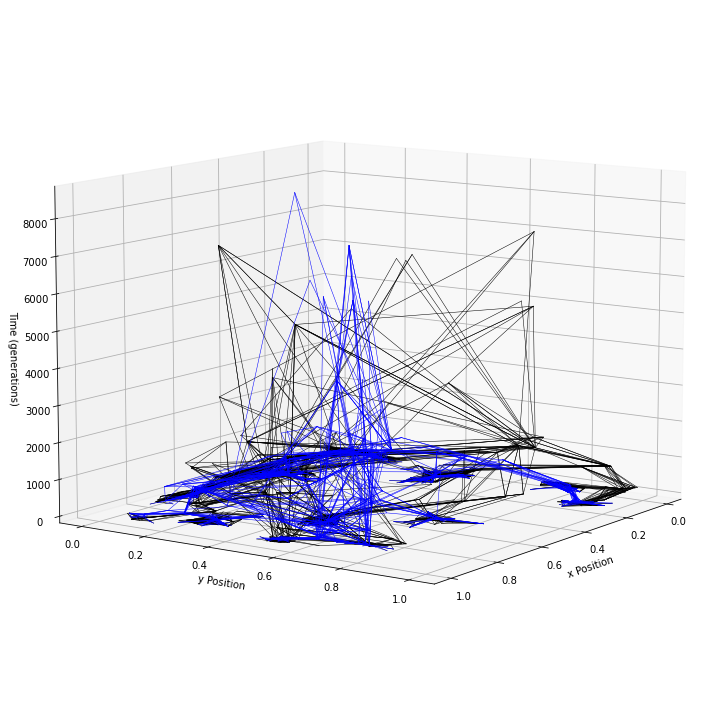

In [66]:
# Let's visualize the tree sequence in three dimensions
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
times = sampled_ts.tables.nodes.time
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = node_locations[edge.child]
        parent_loc = node_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="black", linewidth=0.5)
        
times = slim_inferred_times_marginal
for edge in sampled_ts.edges():
    if edge.parent not in no_location_nodes:
        child_loc = slim_inferred_locations[edge.child]
        parent_loc = slim_inferred_locations[edge.parent]
        ax.plot([child_loc[0], parent_loc[0]], [child_loc[1], parent_loc[1]], [times[edge.child], times[edge.parent]],
               color="blue", linewidth=0.5)

ax.set_xlabel("x Position")
ax.set_ylabel("y Position")
ax.set_zlabel("Time (generations)")
ax.view_init(10, 35)
plt.tight_layout()

In [24]:
# Fixing prior
progress=True
allow_unary=True
span_data = tsdate.prior.SpansBySamples(sampled_ts, progress=progress)

base_priors = ConditionalCoalescentTimes(
    approx_prior_size, Ne, prior_distribution, progress=progress
)

base_priors.add(contmpr_ts.num_samples, approximate_priors)
for total_fixed in span_data.total_fixed_at_0_counts:
    # For missing data: trees vary in total fixed node count => have different priors
    if total_fixed > 0:
        base_priors.add(total_fixed, approximate_priors)

if isinstance(timepoints, int):
    if timepoints < 2:
        raise ValueError("You must have at least 2 time points")
    timepoints = create_timepoints(base_priors, prior_distribution, timepoints + 1)
elif isinstance(timepoints, np.ndarray):
    try:
        timepoints = np.sort(timepoints.astype(base.FLOAT_DTYPE, casting="safe"))
    except TypeError:
        raise TypeError("Timepoints array cannot be converted to float dtype")
    if len(timepoints) < 2:
        raise ValueError("You must have at least 2 time points")
    elif np.any(timepoints < 0):
        raise ValueError("Timepoints cannot be negative")
    elif np.any(np.unique(timepoints, return_counts=True)[1] > 1):
        raise ValueError("Timepoints cannot have duplicate values")
else:
    raise ValueError("time_slices must be an integer or a numpy array of floats")

prior_params_contmpr = base_priors.get_mixture_prior_params(span_data)
# Map the nodes in the prior params back to the node ids in the original ts
prior_params = prior_params_contmpr[node_map, :]

TipCount: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.58it/s]


NameError: name 'ConditionalCoalescentTimes' is not defined